 ![Drugs4Covid](https://drugs4covid.oeg-upm.net/static/media/logo.min.c1d79895.svg) **Drugs4Covid Search Engine**
 

## Preparation

In [0]:
!pip install pysolr

!wget -N "https://raw.githubusercontent.com/oeg-upm/drugs4covid19-nlp/master/notebooks/auxfunctions.py"

## Search

,Article,Paragraph
0,unknown,"Although this development has been encouraging, supply issues in the United States and cardiovascular toxicity concerns limit the use of chloroquine. As an alternative, hydroxychloroquine, a compound that differs from chloroquine only by a single hydroxyl group, has garnered interest. Hydroxychloroq..."
1,unknown,"Overall, 956,374 and 310,350 users of hydroxychloroquine and sulfasalazine, and 323,122 and 351,956 users of hydroxychloroquine-azithromycin and hydroxychloroquine-amoxicillin were included. No excess risk of SAEs was identified when 30-day hydroxychloroquine and sulfasalazine use were compared. SCC..."
2,unknown,Hydroxychloroquine (an analogue of chloroquine) has been demonstrated to have an anti-SARS-CoV activity in vitro [12] . Hydroxychloroquine clinical safety profile is better than that of chloroquine (during long-term use) and allows higher daily dose [13] and has fewer concerns about drug-drug intera...
3,unknown,"The PBPK models for chloroquine and hydroxychloroquine were developed using Simcyp simulator (version 18). The chloroquine compound file was provided by Simcyp Limited (a Certara company, Blades Enterprise Centre, Sheffield, UK) and the hydroxychloroquine compound file was self-built. Physical and c..."
4,unknown,"[10], hydroxychloroquine [11] , and IFN-β-1a [12] as well as reported EC 50 values in vitro 125 (see Table 1 author/funder, who has granted medRxiv a license to display the preprint in perpetuity...."


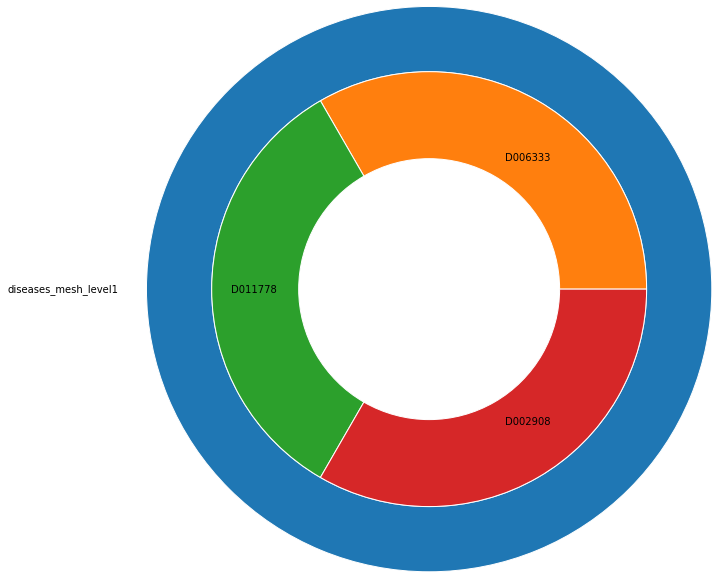

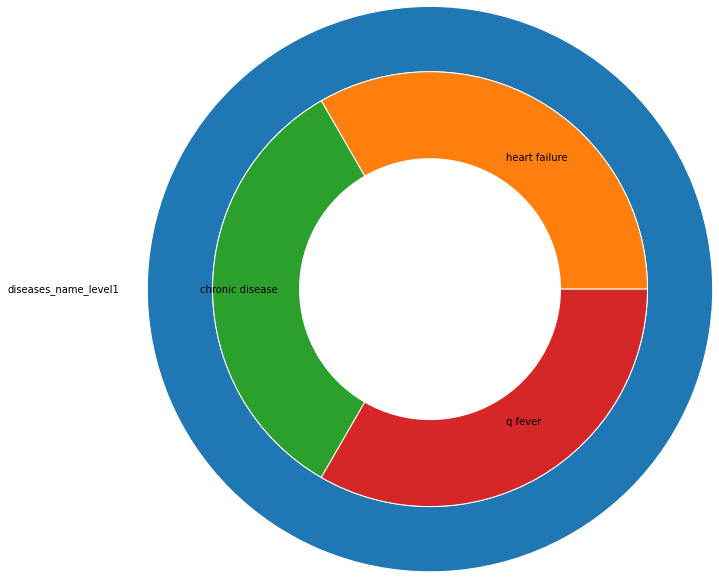

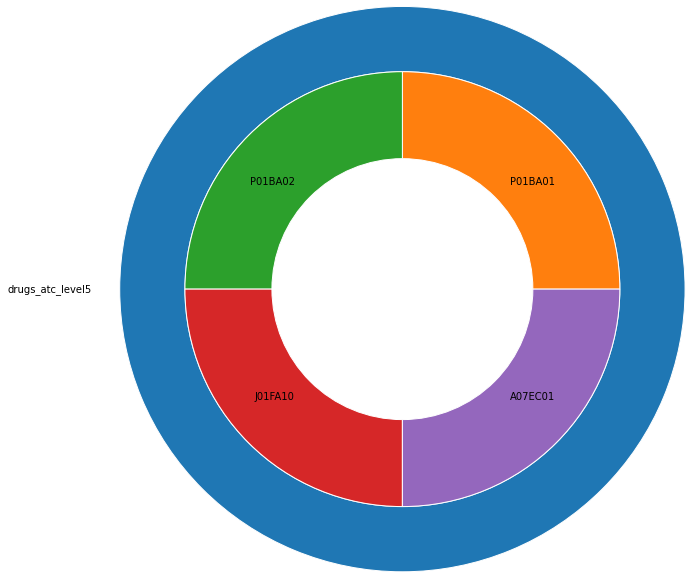

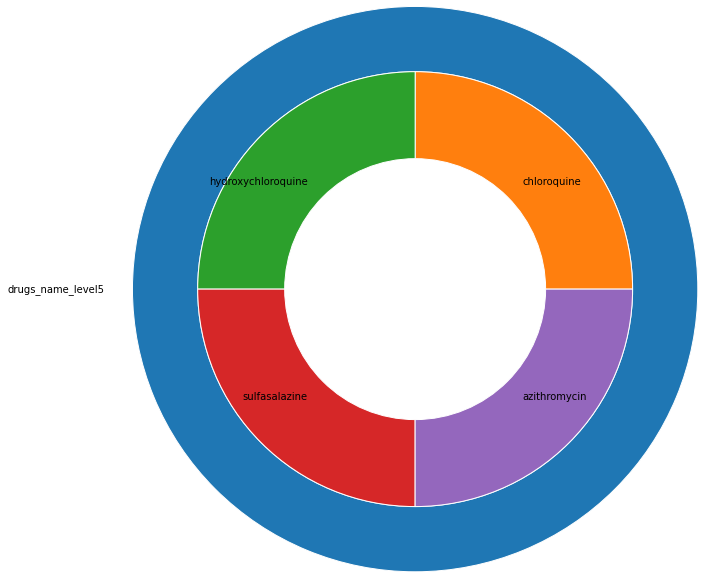

In [4]:
import auxfunctions
import requests
import pysolr
import pandas as pd
from IPython.display import display, HTML
  
keywords =  "Hydroxychloroquine"#@param {type:"string"}

number = 5 #@param {type:"slider", min:1, max:20, step:1}

# Solr collections
solr_drugs = pysolr.Solr('http://librairy.linkeddata.es/data/atc')
solr_diseases = pysolr.Solr('http://librairy.linkeddata.es/data/diseases')
solr_articles = pysolr.Solr('http://librairy.linkeddata.es/data/covid')
solr_paragraphs = pysolr.Solr('http://librairy.linkeddata.es/data/covid-paragraphs')

# keyword as drug
drugs = solr_drugs.search(q="label_t:\""+keywords+"\" or code_s:"+keywords + " or id:" + keywords)
filter_by_drugs = ["bionlp_drugs_C"+str(drug['level_i'])+":"+drug['id'] for drug in drugs]

# keyword as disease
diseases = solr_diseases.search(q="name_t:\""+keywords+"\" or id:"+keywords + " or synonyms:\""+keywords+"\" or mappings=\"" + keywords + "\"")
filter_by_diseases = [ "bionlp_diseases_C"+str(disease['level_i'])+":"+disease['id'] for disease in diseases]
  
# Solr query
solr_query = "text_t:\""+keywords+"\""
for drug_filter in filter_by_drugs:
  solr_query += " or " + drug_filter
for disease_filter in filter_by_diseases:
  solr_query += " or " + disease_filter  

# Get paragraphs
paragraphs = solr_paragraphs.search(q=solr_query,rows=number)

related_drugs_code = {}
related_diseases_code = {}
related_drugs_name = {}
related_diseases_name = {}

articles_df = pd.DataFrame(columns=['Article', 'Paragraph'])
j=0
for paragraph in paragraphs:
  title = "unknown"
  url = ""
  purl="https://librairy.linkeddata.es/solr/covid-paragraphs/select?q=id:"+paragraph['id']
  for r in  solr_articles.search("id:"+paragraph['article_id_s']):
    if ('name_s' in r and 'url_s' in r):
      title = r['name_s']
      url = r['url_s']
  articles_df.loc[j] = [auxfunctions.make_clickable(title,url),auxfunctions.make_clickable(paragraph['text_t'][:300]+"...",purl)]
  for i in range(0,20):
    disease_key = 'bionlp_diseases_C'+str(i)
    if (disease_key in paragraph):
      if (not disease_key in related_diseases_code):
        related_diseases_code[disease_key] = []
        related_diseases_name[disease_key] = []
      related_diseases_code[disease_key].extend(paragraph['bionlp_diseases_C'+str(i)])
      related_diseases_name[disease_key].extend(paragraph['bionlp_diseases_N'+str(i)])
    drug_key = 'bionlp_drugs_C'+str(i)
    if (drug_key in paragraph):
      if (not drug_key in related_drugs_code):
        related_drugs_code[drug_key] = []
        related_drugs_name[drug_key] = []
      related_drugs_code[drug_key].extend(paragraph['bionlp_drugs_C'+str(i)])    
      related_drugs_name[drug_key].extend(paragraph['bionlp_drugs_N'+str(i)])    
  j+=1
  

# Show table of articles
display(HTML(articles_df.to_html(justify='left',escape=False)))
 
# Show plot with diseases 
auxfunctions.build_donut_plot(related_diseases_code,"diseases_mesh").show()
auxfunctions.build_donut_plot(related_diseases_name,"diseases_name").show()

# Show plot with drugs 
auxfunctions.build_donut_plot(related_drugs_code,"drugs_atc").show()
auxfunctions.build_donut_plot(related_drugs_name,"drugs_name").show()
